In [1]:
import matplotlib.pyplot as plt
import numpy as np
import lasagne
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
from scipy.stats import norm
import seaborn as sns
from IPython import display


Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 950M (0000:01:00.0)


In [2]:
# with the huge help of http://evjang.com/articles/genadv1
def sample_noise(M):
#     z = np.float32(np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01)
    z = np.random.normal(loc=0, scale=4, size=M).astype(theano.config.floatX)
    return z

In [3]:
def real_input(M):
#     x = np.hstack((np.random.normal(1,1, int(0.6*M)), np.random.normal(5,1, int(0.6*M)))).astype(theano.config.floatX)
#     x = np.random.normal(1,0.00001, int(M)).astype(theano.config.floatX)
    N = int(M*0.6)
    x1 = np.random.uniform(0,1,N)
    x2 = np.random.uniform(4,5,N)
    x = np.hstack((x1,x2))
    np.random.shuffle(x)
    return x[:M].astype(theano.config.floatX)

In [4]:
sample_noise(10)

array([ 0.43597555,  2.43940258, -1.72216177,  8.26385498,  3.69820857,
       -5.16537905,  0.93559402, -0.41343996, -0.03305461, -1.43731332], dtype=float32)

In [5]:
def plot_fig(generate, discriminate):
    r = 100  # resolution (number of points)
    
    # plots pg, pdata, decision boundary
    xs = real_input(r)
    sns.distplot(xs, hist=False, rug=True)
    
    # decision boundary
    xs = np.float32(np.linspace(-5, 5, r))
    # process multiple points in parallel in same minibatch
    ds = discriminate(xs.reshape(r, 1))
    plt.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs = sample_noise(r)
    gs = generate(zs.reshape(r, 1))
#     plt.hist(gs, bins=10, normed=True)
    sns.distplot(gs, hist=False)

In [6]:
# generator
G_input = T.matrix('G input')
G_layer = lasagne.layers.InputLayer((None, 1), G_input)
G_layer = lasagne.layers.DenseLayer(G_layer, 100, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, 100, nonlinearity=lasagne.nonlinearities.rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, 100, nonlinearity=rectify)
G_layer = lasagne.layers.DenseLayer(G_layer, 1, nonlinearity=linear)
G = G_layer
G_out = lasagne.layers.get_output(G)

#discriminator
D_input = T.matrix('D input')
D_l1 = lasagne.layers.InputLayer((None, 1), D_input)
D_l2 = lasagne.layers.DenseLayer(D_l1, 10, nonlinearity=tanh)
D_l3 = lasagne.layers.DenseLayer(D_l2, 10, nonlinearity=tanh)
D_l4 = lasagne.layers.DenseLayer(D_l3, 1, nonlinearity=sigmoid)
D = D_l4
D_out = lasagne.layers.get_output(D)

DG_l1 = lasagne.layers.InputLayer((None, 1), G_out)
DG_l2 = lasagne.layers.DenseLayer(DG_l1, 10, nonlinearity=tanh, W=D_l2.W, b=D_l2.b)
DG_l3 = lasagne.layers.DenseLayer(DG_l2, 10, nonlinearity=tanh, W=D_l3.W, b=D_l3.b)
DG_l4 = lasagne.layers.DenseLayer(DG_l3, 1, nonlinearity=sigmoid, W=D_l4.W, b=D_l4.b)
DG = DG_l4
DG_out = lasagne.layers.get_output(DG)


D_lr = theano.shared(np.array(0.05, dtype=theano.config.floatX), 'discrminator learning rate')
D_weights = lasagne.layers.get_all_params(D)
D_loss = - (T.log(D_out) + T.log(1 - DG_out)).mean()
D_updates = lasagne.updates.nesterov_momentum(D_loss, D_weights, learning_rate=D_lr, momentum=0.)
D_train = theano.function([D_input, G_input],D_loss, updates=D_updates)
# D_acc = lasagne.objectives.categorical_accuracy()

G_lr = theano.shared(np.array(0.05, dtype=theano.config.floatX), 'discrminator learning rate')
G_weights = lasagne.layers.get_all_params(G)
G_loss = - T.log(DG_out).mean()
G_updates = lasagne.updates.nesterov_momentum(G_loss, G_weights, learning_rate=G_lr, momentum=0.)
G_train = theano.function([G_input], G_loss, updates=G_updates)

In [14]:
# output functions
discriminate = theano.function([D_input], D_out)
generate = theano.function([G_input], G_out)

In [8]:
G_lr.set_value(0.05)
D_lr.set_value(0.05)

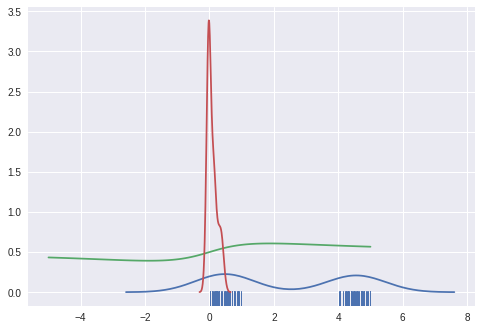

In [9]:
plot_fig(generate, discriminate)
plt.show()

In [10]:
epochs = 4000
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20
M = 200
visualize_training = True  # set to True to monitor training progress

In [16]:
plt.ion()
c = 0
for i in range(epochs):
    for j in range(k):
        x = real_input(M)  # sampled m-batch from p_data
        z = sample_noise(M)  # sample m-batch from noise prior
        histd[i] = D_train(x.reshape(M, 1), z.reshape(M, 1))
    z = sample_noise(M)
    histg[i] = G_train(z.reshape(M, 1))
    if i % 10 == 0:
        G_lr *= 0.999
        D_lr *= 0.999
    if visualize_training and c > 10:
        plt.clf()
        plot_fig(generate, discriminate)
        display.clear_output(wait=True)
        plt.show()
        c = 0
    c = c + 1

KeyboardInterrupt: 

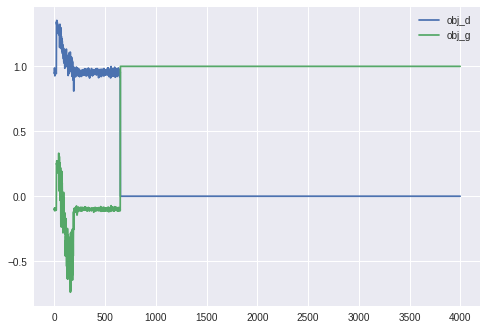

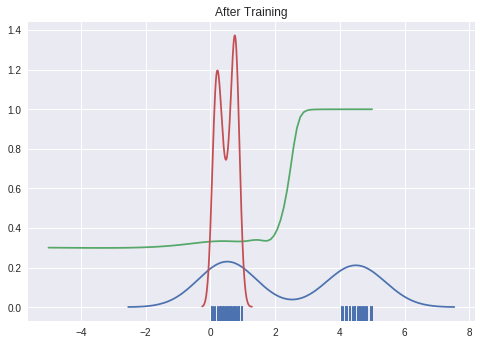

In [15]:
plt.ioff()

plt.clf()
plt.plot(range(epochs), histd, label='obj_d')
plt.plot(range(epochs), 1 - histg, label='obj_g')
plt.legend()
plt.show()

plot_fig(generate, discriminate)
plt.title('After Training')
plt.show()

In [45]:
sample_noise(10).shape

(10,)